#code

In [2]:

import torch
!pip install torch_geometric torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html

import random
import collections
import networkx as nx
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import numpy as np

print("✅ Setup complete. All libraries are installed and imported.")

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
✅ Setup complete. All libraries are installed and imported.


In [3]:
from torch_geometric.datasets import TUDataset
from collections import defaultdict
import hashlib

print("Libraries installed and imported successfully!")

Libraries installed and imported successfully!


## Code from task 7- WL Test and Initial Isomorphism Check

In [4]:
def weisfeiler_lehman_hash(graph):
    """
    Computes a canonical hash for a graph using the 1-WL algorithm (color refinement).
    """
    # colors based on 'label' attribute.
    colors = {node: data.get('label', 0) for node, data in graph.nodes(data=True)}

    # The algorithm is guaranteed to converge in at most n-1 iterations, where n is the number of nodes.
    # Iterating len(graph.nodes()) times is a safe upper bound.
    for _ in range(len(graph.nodes())):
        new_colors = {}
        for node in graph.nodes():
            # sorted list of colors
            neighbor_colors = sorted([colors[nbr] for nbr in graph.neighbors(node)])

            #The new signature - tuple of the node's current color and its neighbors' colors.
            signature = (colors[node], tuple(neighbor_colors))

            # Hash
            new_colors[node] = hash(signature)

        #  not changed , then stabilized.
        if new_colors == colors:
            break
        colors = new_colors

    #sorted list of all final colors.
    canonical_hash = str(sorted(colors.values()))
    return canonical_hash

def find_isomorphic_groups_from_pyg(dataset):
    """
    Takes a PyTorch Geometric dataset and groups graphs by their WL hash.
    """
    hashes = collections.defaultdict(list)

    for i, data in enumerate(dataset):

        #node features as attributes.
        g = to_networkx(data, node_attrs=['x'])


        #initial node label
        nx.set_node_attributes(g, {j: int(x[0]) for j, x in enumerate(data.x)}, 'label')

        # non-empty graphs.
        if len(g) > 0:
            h = weisfeiler_lehman_hash(g)
            hashes[h].append(i) # Group graphs by their hash

    # with only one graph.
    isomorphic_groups = {h: indices for h, indices in hashes.items() if len(indices) > 1}
    return isomorphic_groups

# --- Main Execution ---
print("1. Loading AIDS dataset using PyTorch Geometric...")
try:
    # use_node_attr=True loads the node labels into the `x` attribute
    dataset = TUDataset(root='/tmp/AIDS', name='AIDS', use_node_attr=True)
    print(f"   Successfully loaded {len(dataset)} graphs.")
except Exception as e:
    print(f"Error: Could not download or load the dataset. {e}")
    exit()

print("\n2. Running Weisfeiler-Lehman isomorphism test on the original dataset...")
isomorphic_groups = find_isomorphic_groups_from_pyg(dataset)
print("   Test complete.")

print("\n3. Initial Isomorphism Statistics:")
if not isomorphic_groups:
    print("   No isomorphic graphs were found in the dataset.")
else:
    num_isomorphic_groups = len(isomorphic_groups)
    total_graphs_in_groups = sum(len(indices) for indices in isomorphic_groups.values())
    print(f"   - Total Isomorphic Groups Found: {num_isomorphic_groups}")
    print(f"   - Total Graphs in Isomorphic Groups: {total_graphs_in_groups}")

1. Loading AIDS dataset using PyTorch Geometric...


Processing...
Done!


   Successfully loaded 2000 graphs.

2. Running Weisfeiler-Lehman isomorphism test on the original dataset...
   Test complete.

3. Initial Isomorphism Statistics:
   - Total Isomorphic Groups Found: 84
   - Total Graphs in Isomorphic Groups: 182


## Identify the Largest Isomorphic Group

In [5]:
if not isomorphic_groups:
    print("Cannot proceed without any isomorphic groups. Please check the dataset and WL implementation.")
else:
    #  list of indices of largest group of isomorphic graphs
    largest_group_indices = max(isomorphic_groups.values(), key=len)

    original_hash = None
    for h, indices in isomorphic_groups.items():
        if indices == largest_group_indices:
            original_hash = h
            break

    print(f"Largest isomorphic group found contains {len(largest_group_indices)} graphs.")
    print(f"Graph indices in this group: {largest_group_indices}")
    print(f"Original WL Hash for this group: {original_hash}")

Largest isomorphic group found contains 8 graphs.
Graph indices in this group: [709, 1270, 1454, 1585, 1607, 1809, 1964, 1977]
Original WL Hash for this group: [-7690908336490230382, -7394720300134413289, -6450556768095829849, -6048084031086194898, -5328430628130536153, -4978531546857461926, -3933902793054011885, -3649587394791604611, -3412484967466594644, -1755805232150000683, -1350875490329265759, -1004149069787770626, -2240363494657880, 142678482780494413, 497613289230940888, 854606272984413655, 1068467177876047519, 1648339303597731766, 1985054178799771764, 2326505697607001102, 2326505697607001102, 2488350187369255156, 3762344997673989006, 3936758843257434709, 7948370797978090239, 8391444319476065906, 9196828898150043023]


Visualizing a sample of the original isomorphic graphs...
   Saved plot to 'original_isomorphic_graphs.png'


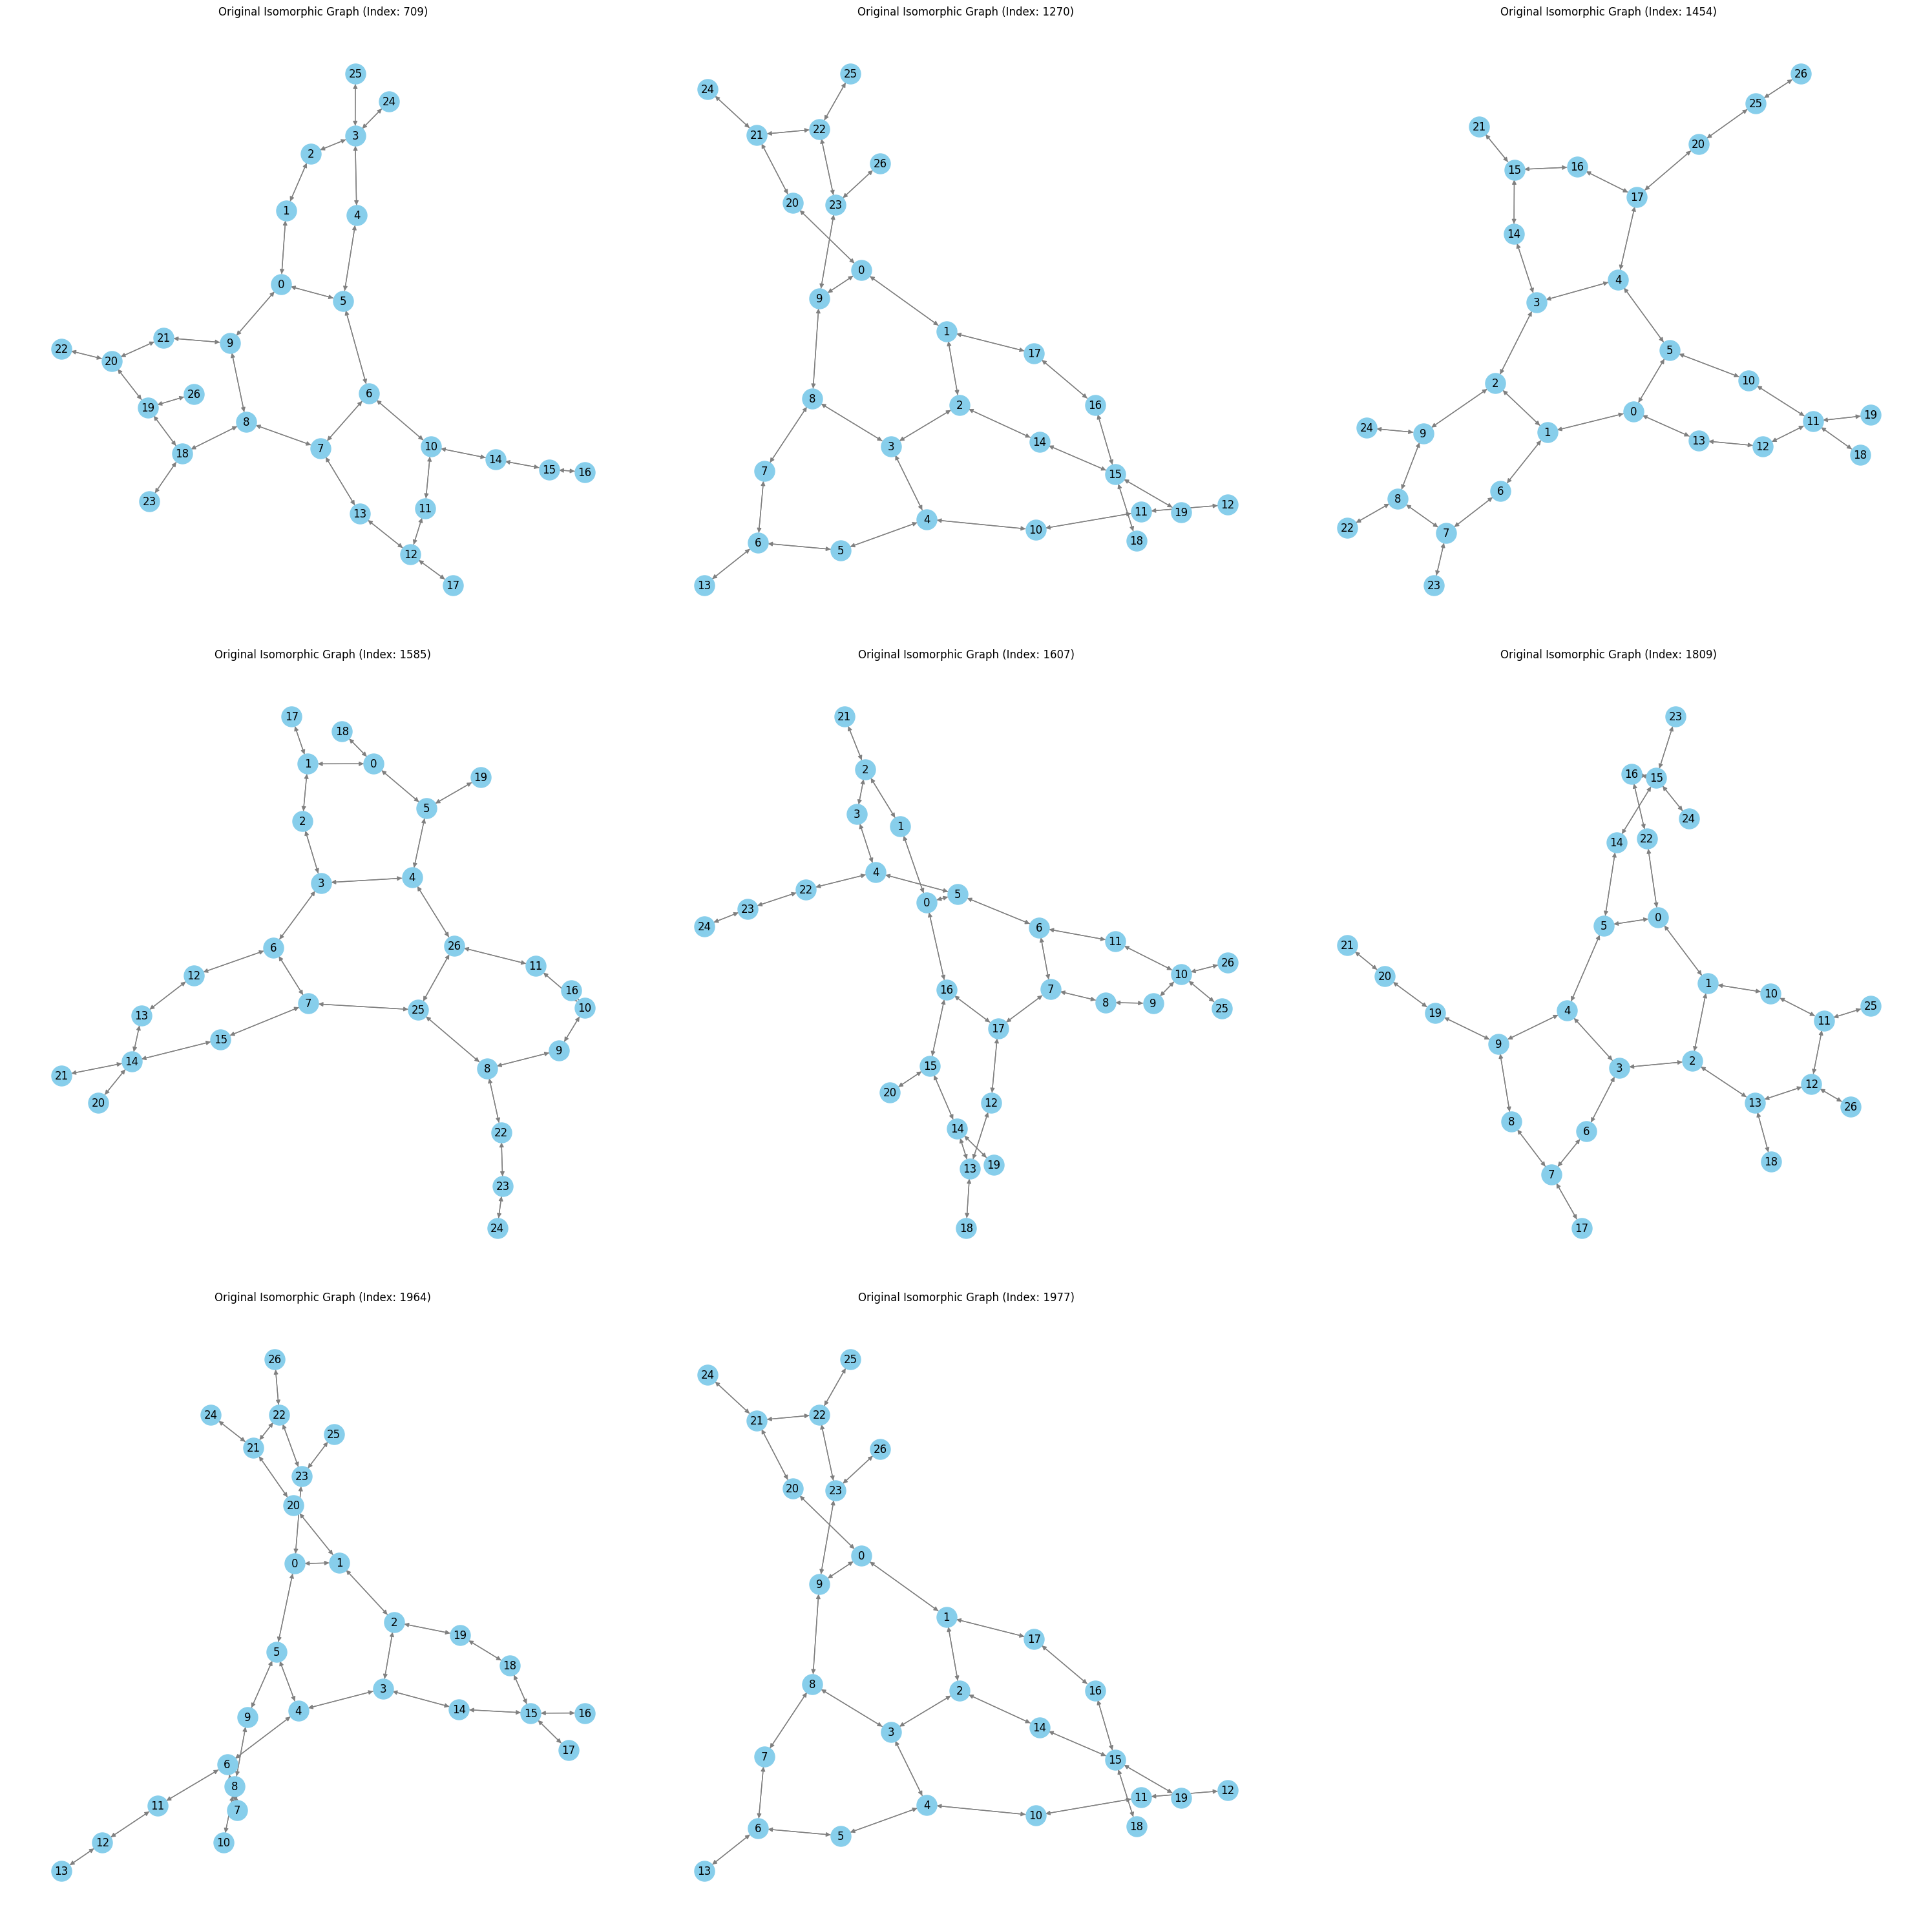

In [6]:

print("Visualizing a sample of the original isomorphic graphs...")

graphs_to_show = min(len(largest_group_indices), 8)
plt.figure(figsize=(30, 30))

for i in range(graphs_to_show):
    ax = plt.subplot(3, 3, i + 1)
    graph_idx = largest_group_indices[i]
    pyg_data = dataset[graph_idx]
    g = to_networkx(pyg_data)

    # Use spring layout for better visualization
    pos = nx.spring_layout(g, seed=42)
    nx.draw(g, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
    ax.set_title(f"Original Isomorphic Graph (Index: {graph_idx})")

plt.tight_layout()
plt.savefig("original_isomorphic_graphs.png")
print("   Saved plot to 'original_isomorphic_graphs.png'")
plt.show()

## Perturbation Function

In [7]:
def perturb_graph(graph: nx.Graph) -> nx.Graph:
    """
    Takes a NetworkX graph and returns a new graph with one random perturbation.
    The perturbation is either adding one non-existent edge or removing one existing edge.

    Args:
        graph: The input NetworkX graph.

    Returns:
        A new NetworkX graph object with a single modification.
    """
    #  copy to avoid modifying the original graph
    perturbed_g = graph.copy()
    nodes = list(perturbed_g.nodes())

    # graph has no edges- add one.
    # graph is complete -remove one.
    num_nodes = len(nodes)
    num_edges = len(perturbed_g.edges())
    is_complete = num_edges == (num_nodes * (num_nodes - 1)) / 2

    if num_edges == 0:
        action = 'add'
    elif is_complete:
        action = 'remove'
    else:
        action = random.choice(['add', 'remove'])

    if action == 'add':
        while True:
            u, v = random.sample(nodes, 2)
            if not perturbed_g.has_edge(u, v):
                perturbed_g.add_edge(u, v)
                # print(f"Added edge ({u}, {v})") # for debugging
                return perturbed_g

    elif action == 'remove':
        #remove random edge
        u, v = random.choice(list(perturbed_g.edges()))
        perturbed_g.remove_edge(u, v)
        # print(f"Removed edge ({u}, {v})") # for debugging
        return perturbed_g

In [8]:
original_graphs = []
perturbed_graphs = []

print(f"Generating 10 perturbed copies for each of the {len(largest_group_indices)} graphs in the largest group...")

for graph_idx in largest_group_indices:
    # 1. original graph
    pyg_data = dataset[graph_idx]
    original_g = to_networkx(pyg_data, node_attrs=['x'])
    nx.set_node_attributes(original_g, {j: int(x[0]) for j, x in enumerate(pyg_data.x)}, 'label')
    original_graphs.append({'graph': original_g, 'original_index': graph_idx})

    # 2. 10 perturbed copies
    for i in range(10):
        perturbed_g = perturb_graph(original_g)
        perturbed_graphs.append({
            'graph': perturbed_g,
            'original_index': graph_idx,
            'perturbation_num': i + 1
        })

total_graphs = len(original_graphs) + len(perturbed_graphs)
print(f"\nGeneration complete.")
print(f"Total graphs in our experiment: {total_graphs}")
print(f"({len(original_graphs)} original graphs + {len(perturbed_graphs)} perturbed graphs)")

Generating 10 perturbed copies for each of the 8 graphs in the largest group...

Generation complete.
Total graphs in our experiment: 88
(8 original graphs + 80 perturbed graphs)



Visualizing an example of a single graph and its perturbed copies...
   -> Saved plot to 'graph_perturbation_example.png'


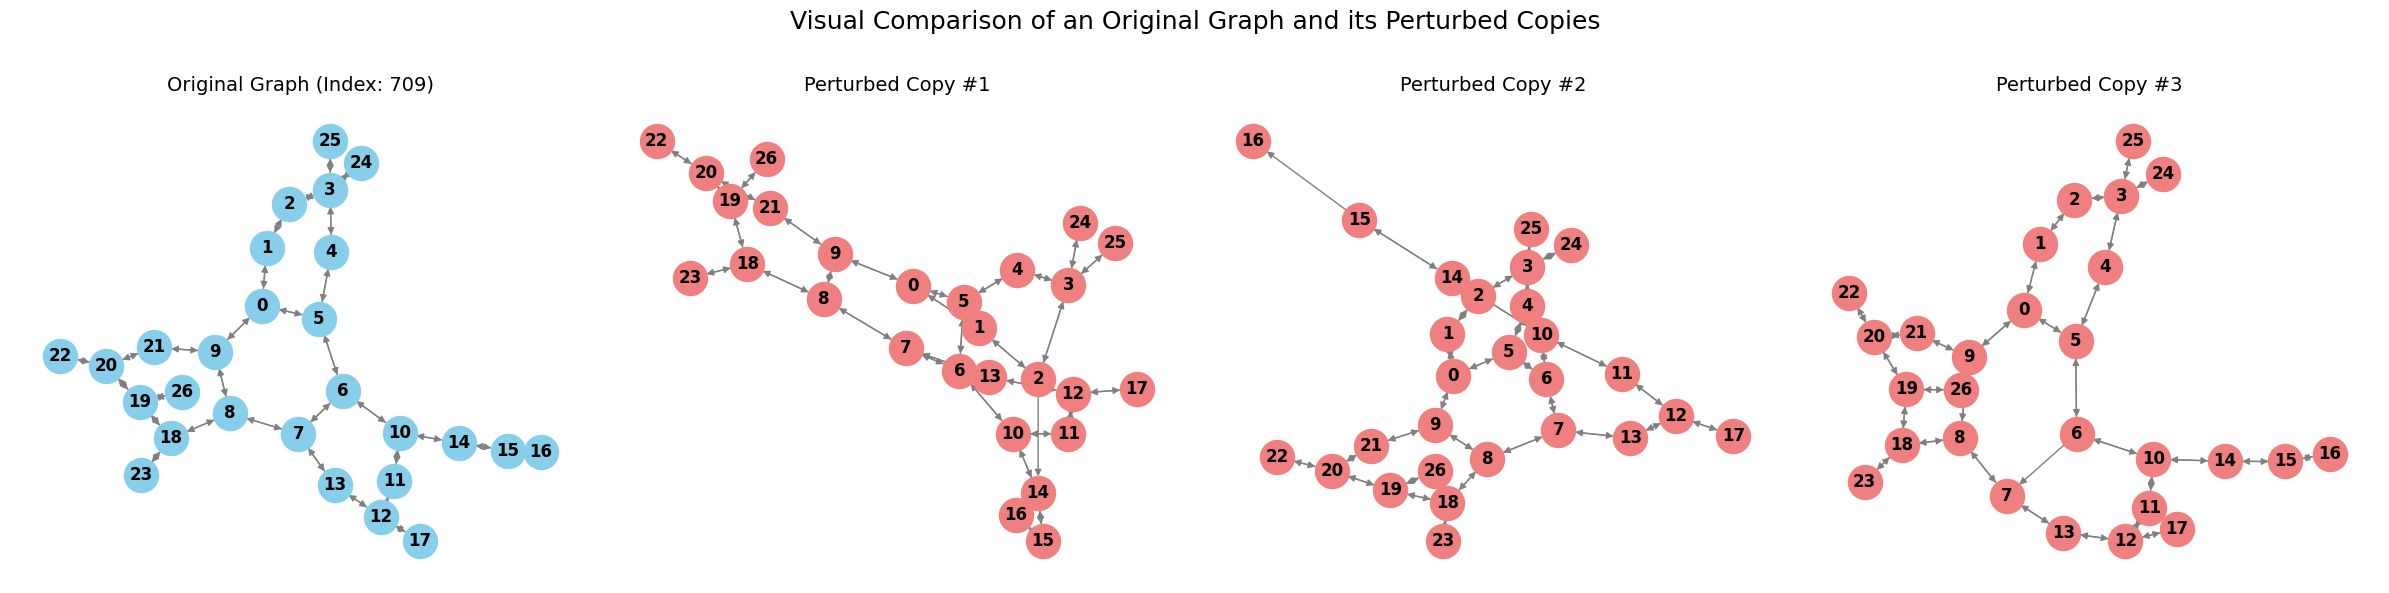

In [9]:

print("\nVisualizing an example of a single graph and its perturbed copies...")

#  first original graph
original_example_info = original_graphs[0]
original_example_graph = original_example_info['graph']
original_example_idx = original_example_info['original_index']

# Find the first 3 perturbed copies
perturbed_examples = [p['graph'] for p in perturbed_graphs if p['original_index'] == original_example_idx][:3]

#  3 perturbed copies
plt.figure(figsize=(24, 6))
plt.suptitle(f'Visual Comparison of an Original Graph and its Perturbed Copies', fontsize=18)

# 1.  Original Graph
ax1 = plt.subplot(1, 4, 1)
pos_original = nx.spring_layout(original_example_graph, seed=42) # Use a seed for consistent layout
nx.draw(original_example_graph, pos_original, with_labels=True, node_color='skyblue',
        node_size=600, edge_color='gray', font_weight='bold')
ax1.set_title(f"Original Graph (Index: {original_example_idx})", fontsize=14)

# 2. Perturbed Copies
for i, p_graph in enumerate(perturbed_examples):
    ax = plt.subplot(1, 4, i + 2)
    pos_perturbed = nx.spring_layout(p_graph, seed=42) # Use the same seed
    nx.draw(p_graph, pos_perturbed, with_labels=True, node_color='lightcoral',
            node_size=600, edge_color='gray', font_weight='bold')
    ax.set_title(f"Perturbed Copy #{i+1}", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("graph_perturbation_example.png")
print("   -> Saved plot to 'graph_perturbation_example.png'")
plt.show()

##Run WL Test on the New Collection

In [10]:
print("Combining original and perturbed graphs into a single collection...")
# 88 graphs for the experiment.
all_experiment_graphs = []
for graph_info in original_graphs:
    graph_info['type'] = 'original'
    all_experiment_graphs.append(graph_info)

for graph_info in perturbed_graphs:
    graph_info['type'] = 'perturbed'
    all_experiment_graphs.append(graph_info)

print(f"Total graphs in the collection: {len(all_experiment_graphs)}")
print("\nRunning WL Test on the entire new collection...")

# group graphs by their new hash.
experiment_hashes = collections.defaultdict(list)

for graph_info in all_experiment_graphs:
    h = weisfeiler_lehman_hash(graph_info['graph'])
    experiment_hashes[h].append(graph_info)

print("Analysis complete.")

intact_count = 0
broken_count = 0

# group corresponding to the original hash
# Any perturbed graphs - 'intact'.
if original_hash in experiment_hashes:
    original_group_after_test = experiment_hashes[original_hash]
    for graph_info in original_group_after_test:
        if graph_info['type'] == 'perturbed':
            intact_count += 1

# The number of broken graphs = total number of perturbed graphs- minus those that remained intact.
broken_count = len(perturbed_graphs) - intact_count


print("\n--- Experiment A: Noise and Robustness Results ---")
print(f"Original Isomorphic Group Size: {len(original_graphs)} graphs")
print(f"Number of Perturbed Copies Generated: {len(perturbed_graphs)}")
print("-" * 50)
print(f"Isomorphic relationships BROKEN by a single perturbation: {broken_count}")
print(f"Isomorphic relationships that REMAINED INTACT: {intact_count}")
print("-" * 50)

# Calculate and display percentages
total_perturbed = len(perturbed_graphs)
if total_perturbed > 0:
    percent_broken = (broken_count / total_perturbed) * 100
    percent_intact = (intact_count / total_perturbed) * 100
    print(f"Robustness Score: {percent_intact:.2f}% of perturbations did not break the WL isomorphism.")
    print(f"Fragility Score: {percent_broken:.2f}% of perturbations broke the WL isomorphism.")



Combining original and perturbed graphs into a single collection...
Total graphs in the collection: 88

Running WL Test on the entire new collection...
Analysis complete.

--- Experiment A: Noise and Robustness Results ---
Original Isomorphic Group Size: 8 graphs
Number of Perturbed Copies Generated: 80
--------------------------------------------------
Isomorphic relationships BROKEN by a single perturbation: 80
Isomorphic relationships that REMAINED INTACT: 0
--------------------------------------------------
Robustness Score: 0.00% of perturbations did not break the WL isomorphism.
Fragility Score: 100.00% of perturbations broke the WL isomorphism.


Generating a summary chart of the results...
   Saved plot to 'perturbation_results_pie_chart.png'


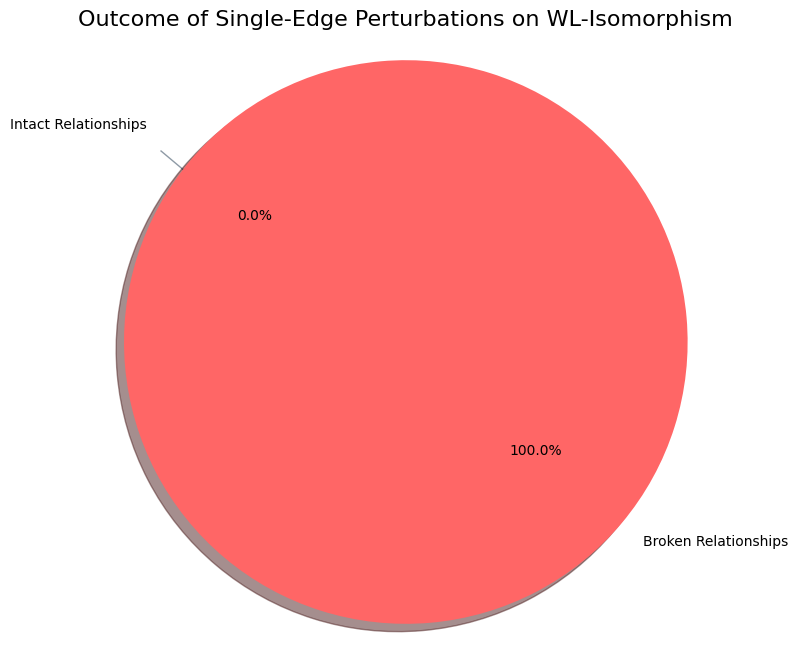

In [11]:
print("Generating a summary chart of the results...")

labels = ['Broken Relationships', 'Intact Relationships']
sizes = [broken_count, intact_count]
colors = ['#ff6666', '#66b3ff']
explode = (0.1, 0) if broken_count > 0 else (0, 0)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Outcome of Single-Edge Perturbations on WL-Isomorphism', fontsize=16)
plt.axis('equal')
plt.savefig("perturbation_results_pie_chart.png")
print("   Saved plot to 'perturbation_results_pie_chart.png'")
plt.show()

##Newly formed isomorphic relationships

In [12]:
print("Searching for new isomorphic relationships among the 80 perturbed graphs...")

# A listofnew groups
new_isomorphic_groups = []

# Iterate through the hash groups
for current_hash, graph_info_list in experiment_hashes.items():
    # We skip  original group,
    if current_hash == original_hash:
        continue

    # An isomorphic group > one graph
    if len(graph_info_list) > 1:
        #  found one! store the details.
        new_isomorphic_groups.append(graph_info_list)

if not new_isomorphic_groups:
    print("\n✅ Analysis Complete: No new isomorphic relationships were formed.")
    print("   Each of the 80 perturbations resulted in a structurally unique graph (according to the WL test).")
else:
    print(f"\n✅ Analysis Complete: Found {len(new_isomorphic_groups)} new isomorphic group(s)!")
    for i, group in enumerate(new_isomorphic_groups):
        print(f"\n--- New Group {i+1} ---")
        print(f"Number of graphs in this new group: {len(group)}")
        print("Details of the graphs:")
        for graph_info in group:
            original_idx = graph_info['original_index']
            pert_num = graph_info['perturbation_num']
            print(f"  - From Original Graph Index: {original_idx}, Perturbation #{pert_num}")


Searching for new isomorphic relationships among the 80 perturbed graphs...

✅ Analysis Complete: Found 11 new isomorphic group(s)!

--- New Group 1 ---
Number of graphs in this new group: 4
Details of the graphs:
  - From Original Graph Index: 709, Perturbation #3
  - From Original Graph Index: 1454, Perturbation #2
  - From Original Graph Index: 1964, Perturbation #2
  - From Original Graph Index: 1977, Perturbation #10

--- New Group 2 ---
Number of graphs in this new group: 3
Details of the graphs:
  - From Original Graph Index: 709, Perturbation #8
  - From Original Graph Index: 1454, Perturbation #7
  - From Original Graph Index: 1809, Perturbation #3

--- New Group 3 ---
Number of graphs in this new group: 3
Details of the graphs:
  - From Original Graph Index: 709, Perturbation #10
  - From Original Graph Index: 1270, Perturbation #4
  - From Original Graph Index: 1977, Perturbation #6

--- New Group 4 ---
Number of graphs in this new group: 3
Details of the graphs:
  - From Or

✅ Found 11 new isomorphic groups. Generating a plot for each...
   -> Saved plot to 'newly_formed_isomorphic_group_1.png'


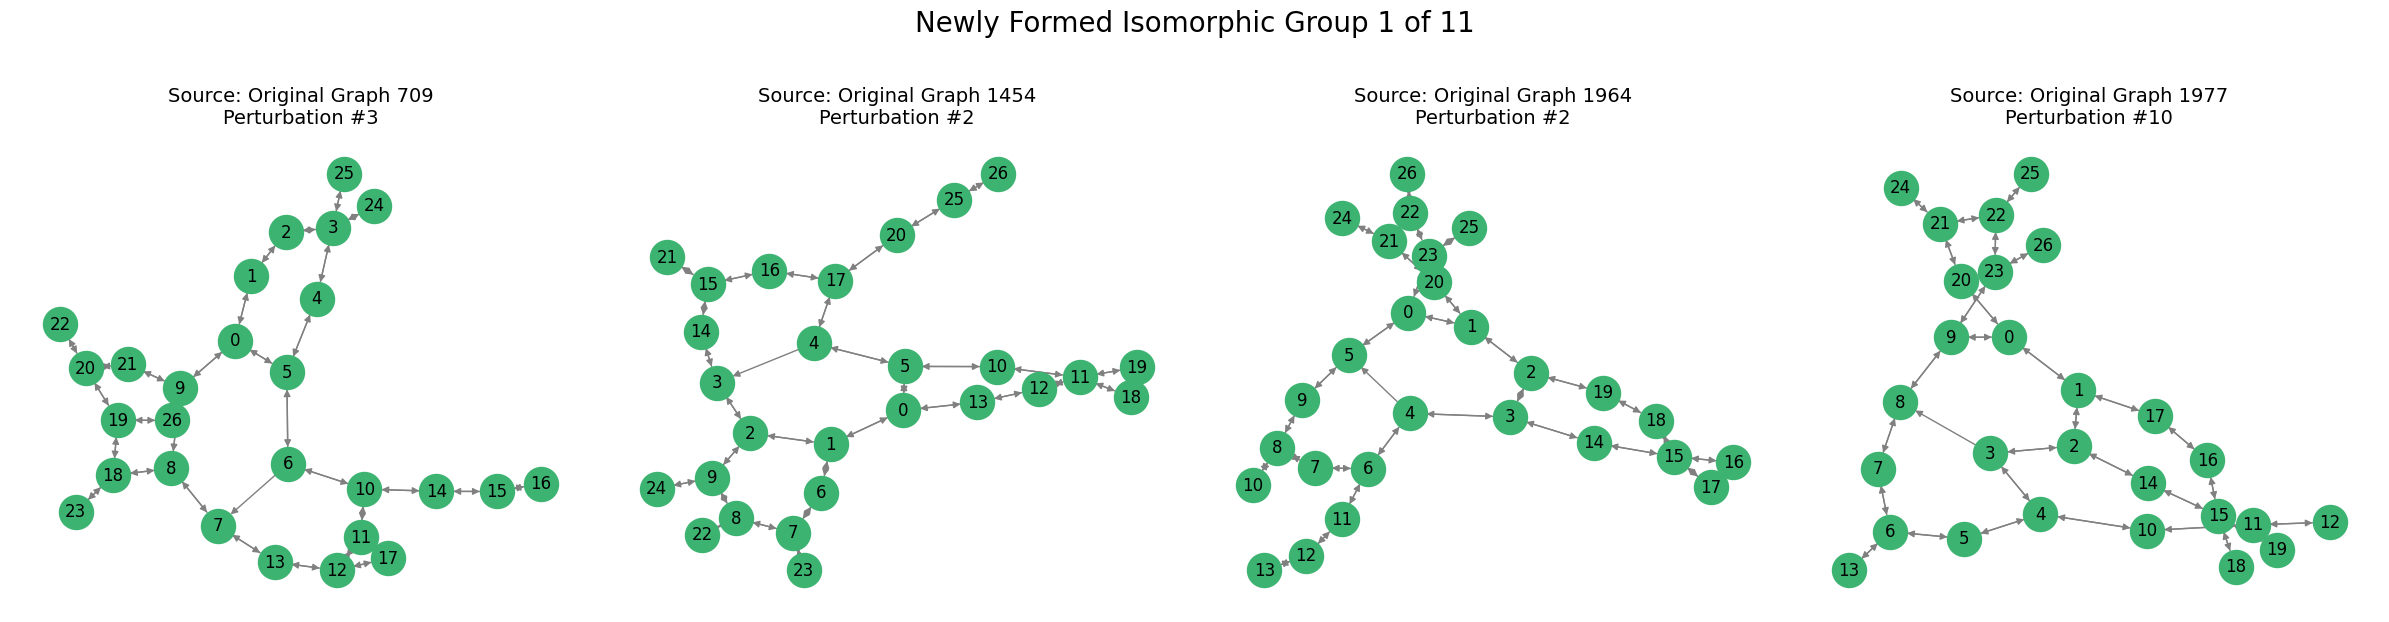

   -> Saved plot to 'newly_formed_isomorphic_group_2.png'


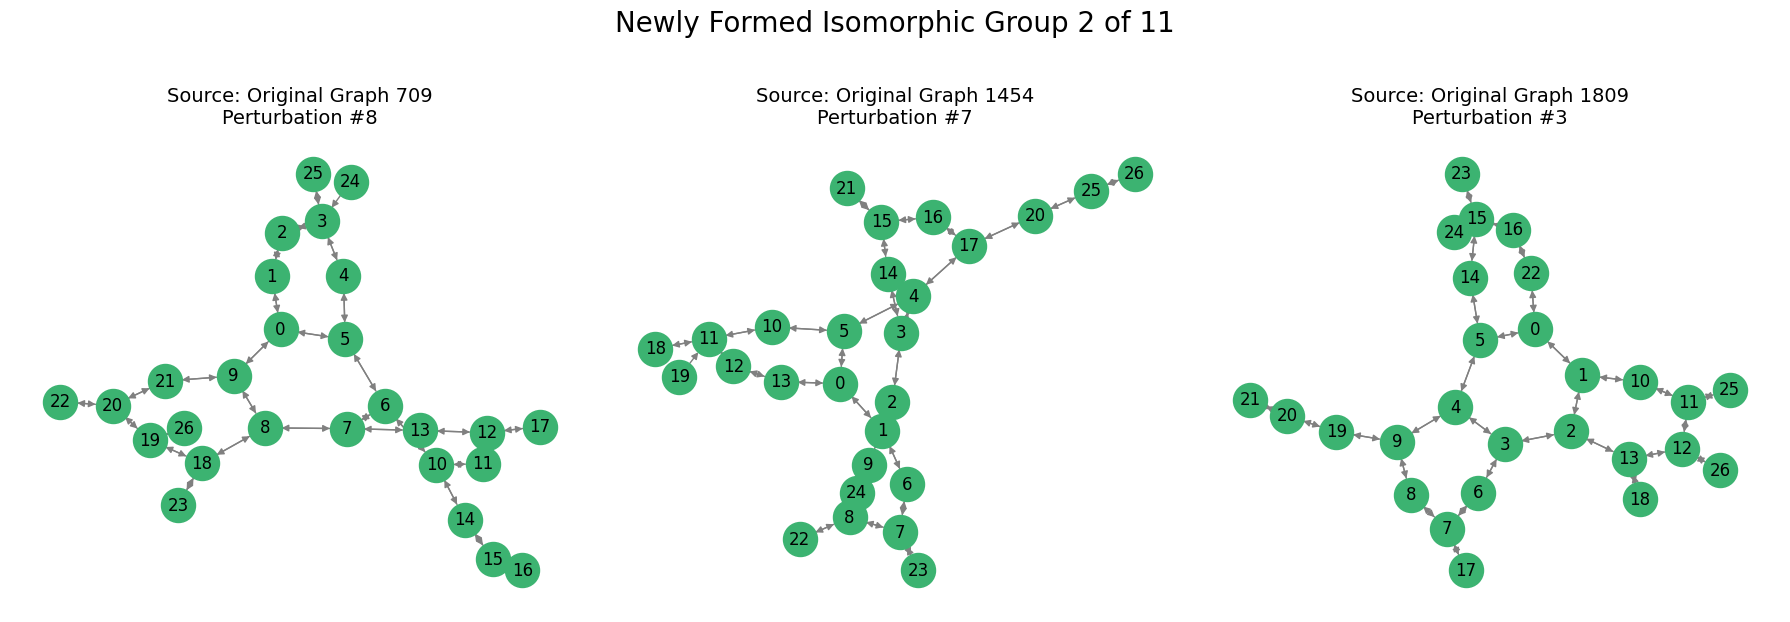

   -> Saved plot to 'newly_formed_isomorphic_group_3.png'


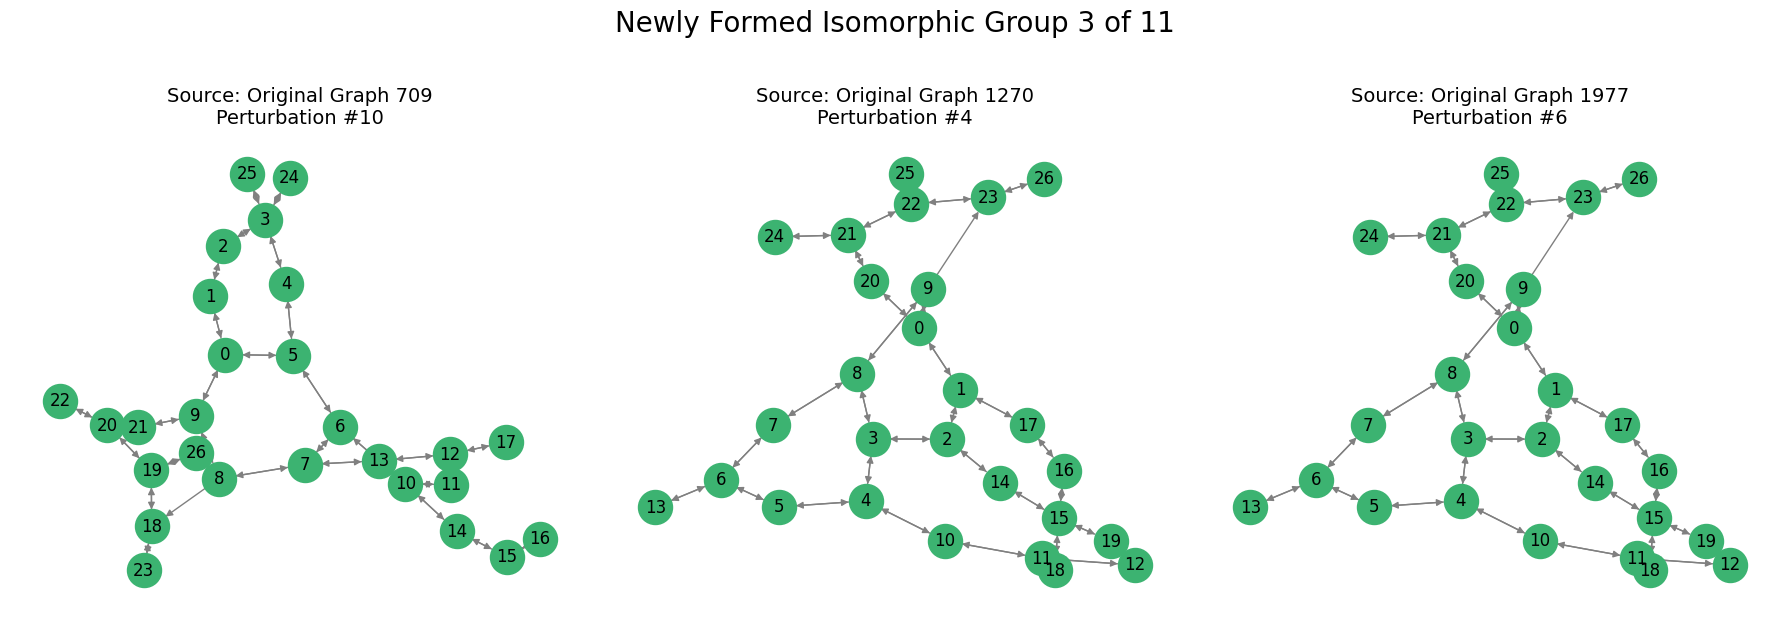

   -> Saved plot to 'newly_formed_isomorphic_group_4.png'


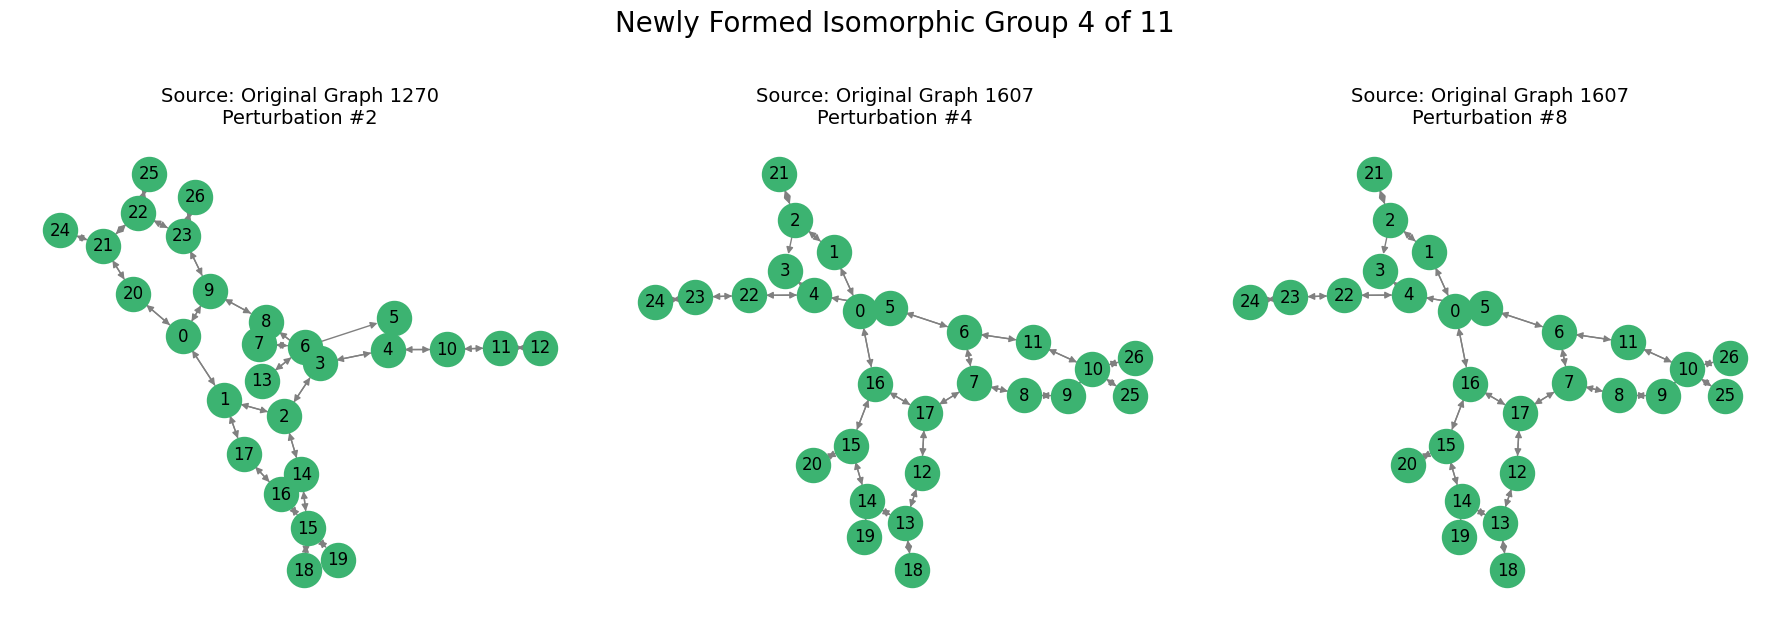

   -> Saved plot to 'newly_formed_isomorphic_group_5.png'


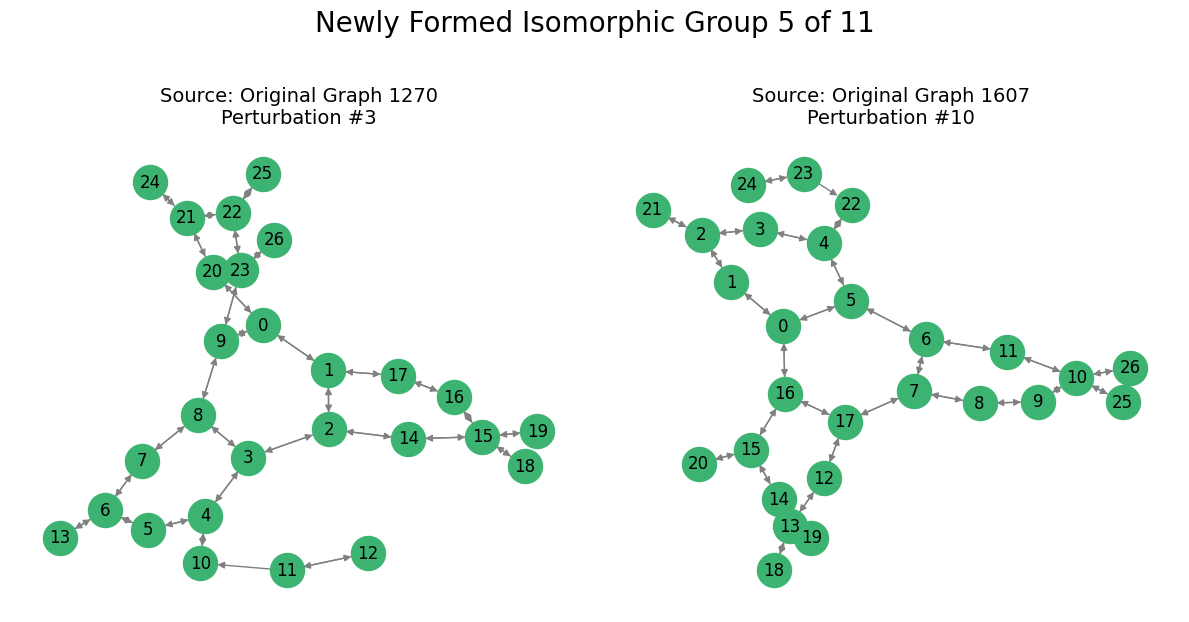

   -> Saved plot to 'newly_formed_isomorphic_group_6.png'


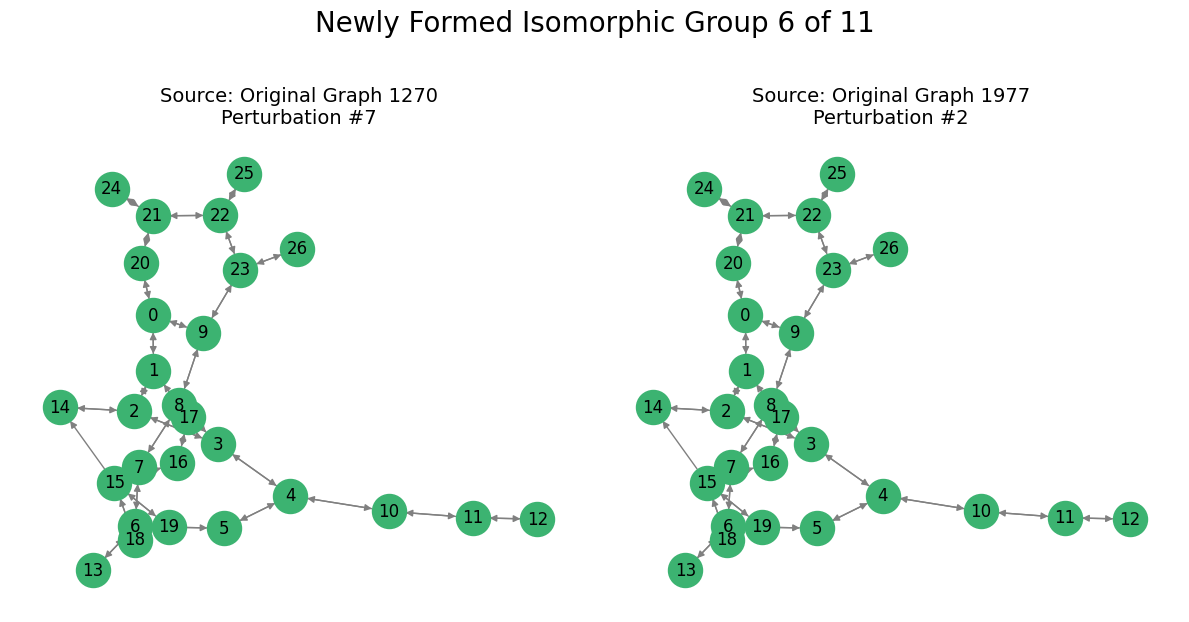

   -> Saved plot to 'newly_formed_isomorphic_group_7.png'


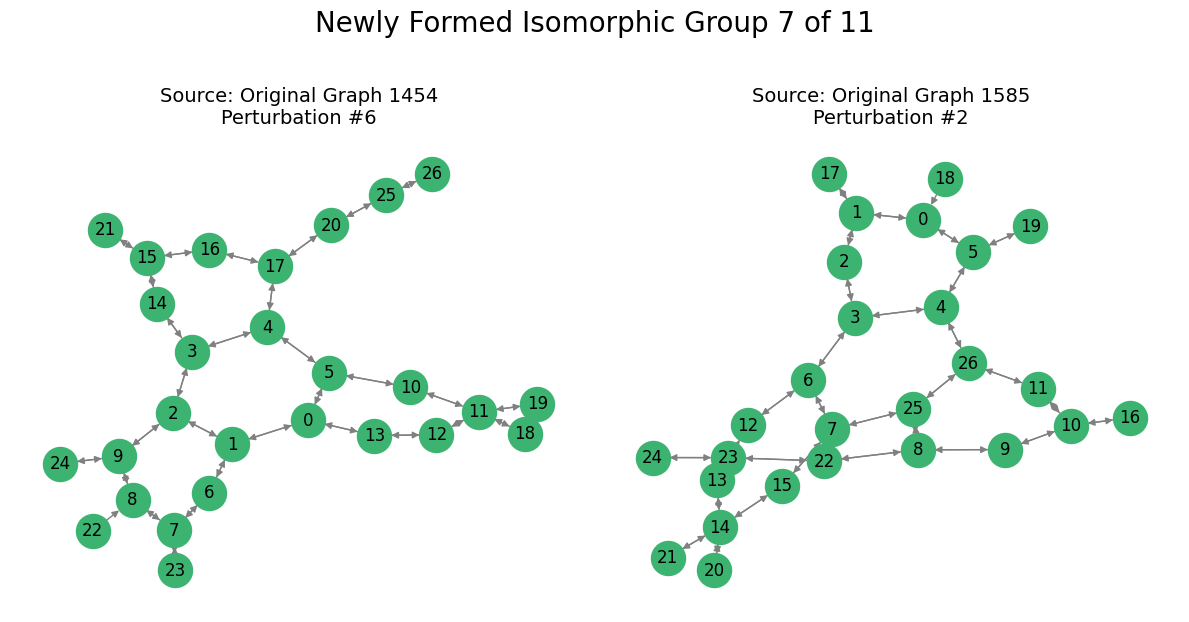

   -> Saved plot to 'newly_formed_isomorphic_group_8.png'


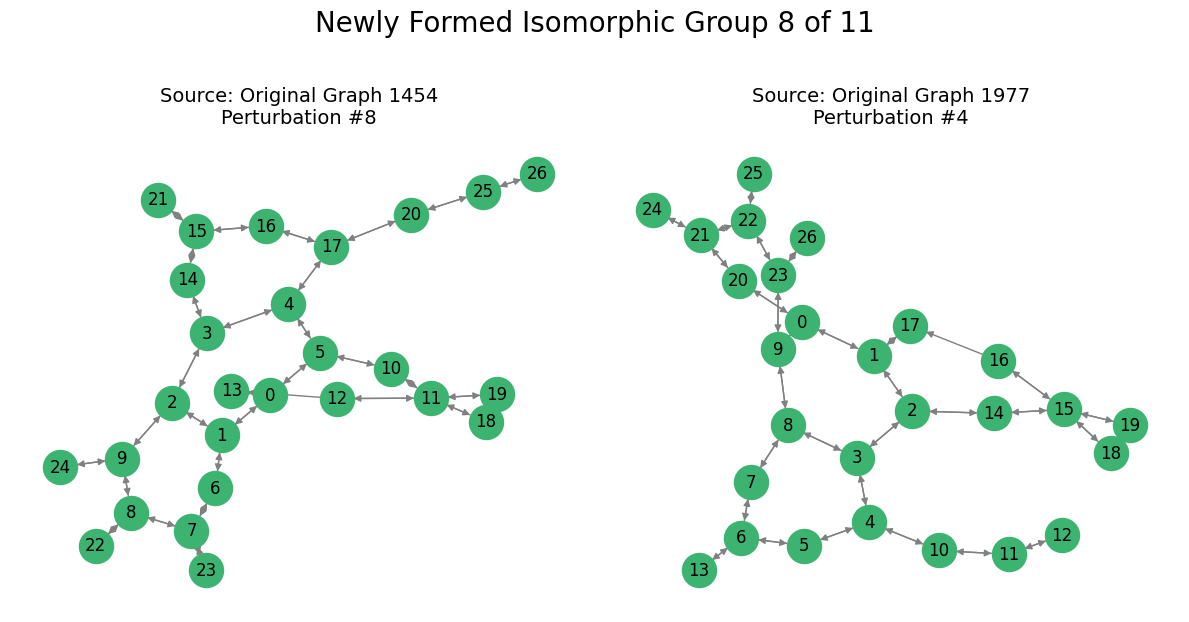

   -> Saved plot to 'newly_formed_isomorphic_group_9.png'


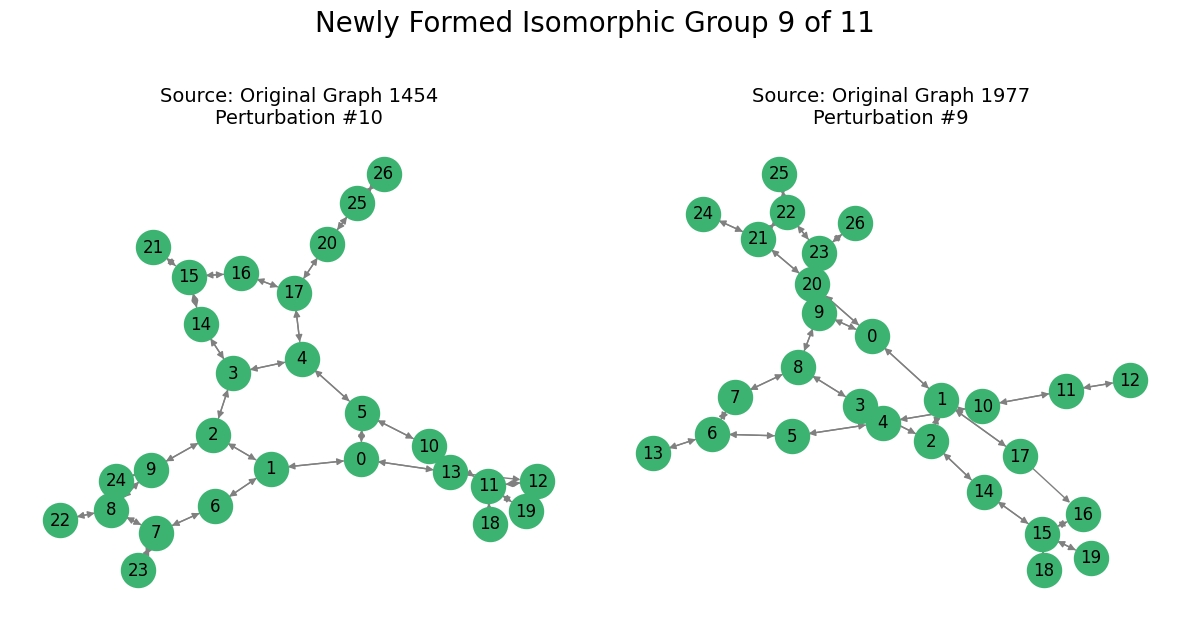

   -> Saved plot to 'newly_formed_isomorphic_group_10.png'


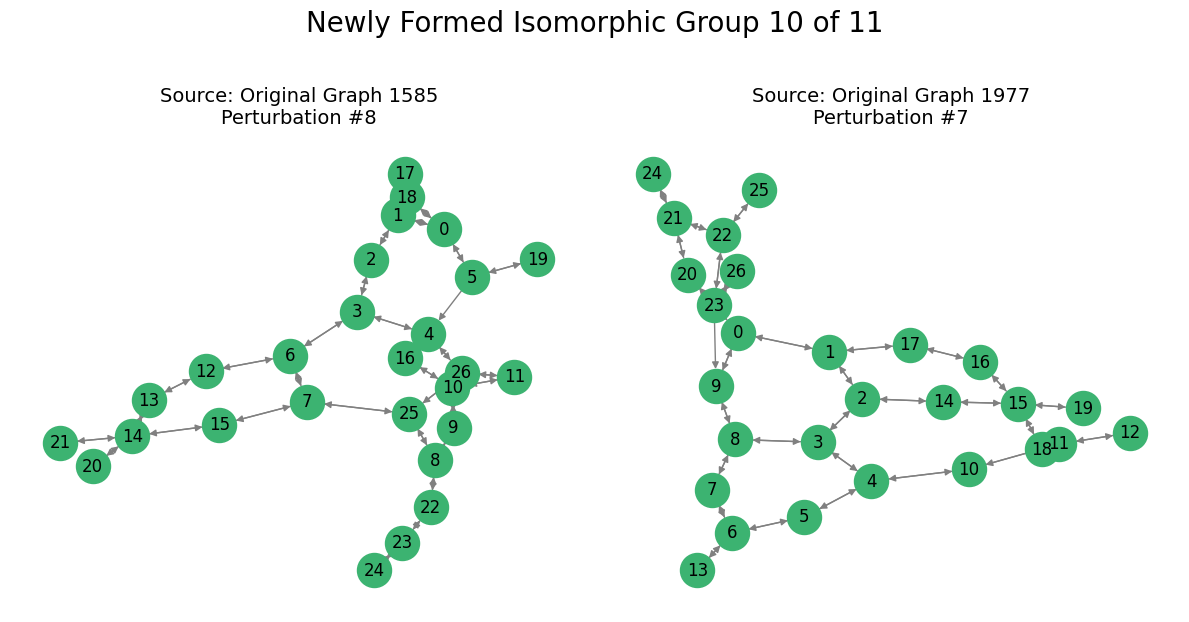

   -> Saved plot to 'newly_formed_isomorphic_group_11.png'


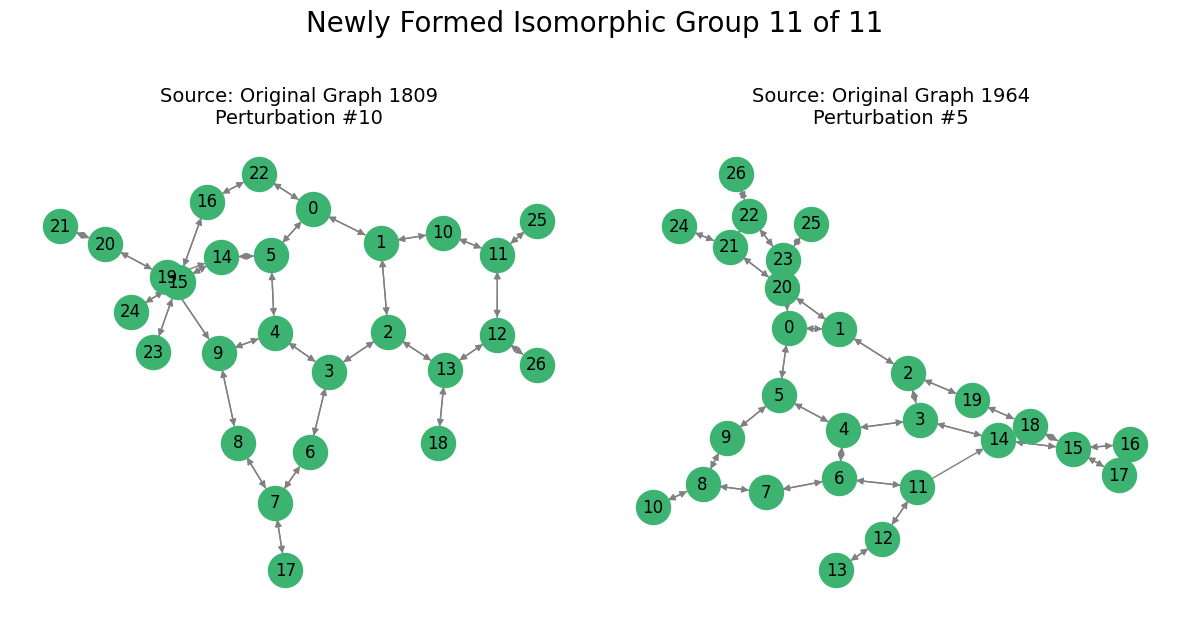


✅ All new isomorphic groups have been visualized.


In [13]:
if not new_isomorphic_groups:
    print("No new isomorphic groups were found, so there is nothing to visualize.")
else:
    print(f"✅ Found {len(new_isomorphic_groups)} new isomorphic groups. Generating a plot for each...")

    for i, group_to_visualize in enumerate(new_isomorphic_groups):

        num_graphs_in_group = len(group_to_visualize)

        plt.figure(figsize=(6 * num_graphs_in_group, 6.5))

        main_title = f"Newly Formed Isomorphic Group {i + 1} of {len(new_isomorphic_groups)}"
        plt.suptitle(main_title, fontsize=20, y=0.98)

        for j, graph_info in enumerate(group_to_visualize):
            ax = plt.subplot(1, num_graphs_in_group, j + 1)

            # Extract the graph and its origin details for labeling.
            g = graph_info['graph']
            original_idx = graph_info['original_index']
            pert_num = graph_info['perturbation_num']

            pos = nx.spring_layout(g, seed=42)

            nx.draw(g, pos, with_labels=True, node_color='mediumseagreen',
                    node_size=600, edge_color='gray', font_size=12)

            ax.set_title(f"Source: Original Graph {original_idx}\nPerturbation #{pert_num}", fontsize=14)


        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        filename = f"newly_formed_isomorphic_group_{i + 1}.png"
        plt.savefig(filename)
        print(f"   -> Saved plot to '{filename}'")

        plt.show()

print("\n✅ All new isomorphic groups have been visualized.")